## Multilingual Named Entity Recognition

The goal of this analysis is to perform **Named Entity Recognition** for a Customer based in Switzerlan, where there are four national languages (with English often serving as a bridge between them). 

#### The Dataset

we will be using a subset of the Cross-lingual TRansfer Evaluation of Multilingual Encoders (XTREME) benchmark called WikiANN or PAN-X.2 This dataset consists of Wikipedia articles in many languages, including the four most commonly spoken languages in Switzerland: German (62.9%),French (22.9%), Ital ian (8.4%), and English (5.9%). Each article is annotated with LOC (location), PER (person), and ORG (organization) tags in the “inside-outside-beginning” (IOB2) format. In this format, a B- prefix indicates the beginning of an entity, and consecutive tokens belonging to the same entity are given an I- prefix.


In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [3]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

We've identified the syntax of PAN-X subsets. Each one has a two letter suffix that appears to be an ISO 639-1 language code. This mean that to load the German corpus, we pass the **de code** to the name argument of `load_dataset()` as follows:

In [4]:
from datasets import load_dataset

load_dataset("xtreme", name = "PAN-X.de")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

To make a realistic Swiss corpus, we’ll sample the German (de), French (fr), Italian (it), and English (en) corpora from PAN-X according to their spoken proportions. This will create a language imbalance that is very common in real-world datasets, where acquiring labeled examples in a minority language can be expensive due to the lack of domain experts who are fluent in that language. This imbalanced dataset will simulate a common situation when working on multilingual applications, and we’ll see how we can build a model that works on all languages.

In [ ]:
## Create a Python defaultdict that stores the language code as key and a PAN-X corpus of type DatasetDict as the value.

from collections import defaultdict
from datasets import DatasetDict

langs = ['de', 'fr', 'it', 'en']
fracs = [0.629, 0.229, 0.084, 0.059]

## Return a DatasetDict if a key doesnt exit
panx_ch = defaultdict(DatasetDict)
for lang, frac in zip(langs, fracs):
    ## Load monolingual corpus
    ds = load_dataset("xtreme", name = f"PAN-X.{lang}")
    ## Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed = 0)                 ## shuffle assures we dont accidentally bias our dataset splits.
            .select(range(int(frac * ds[split].num_rows)))        ## select allows us to downsample each corpus according to value in fracs.
        )

In [6]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index = ["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


By design, we have more examples in German than all other languages combined, so we’ll use it as a starting point from which to perform zero-shot cross-lingual transfer to French, Italian, and English.
Let's inspect one of the examples in the German corpus.

In [8]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


As with our previous encounters with Dataset objects, the keys of our example correspond to the column names of an Arrow table, while the values denote the entries in each column. In particular, we see that the ner_tags column corresponds to the mapping of each entity to a class ID. This is a bit cryptic to the human eye, so let’s create a new column with the familiar LOC, PER, and ORG tags.

In [9]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [10]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


We can use the `ClassLabel.int2str()` method to create a new column in our training set with class names for each tag. We'll use the `map()` method to return a dict with the key corresponding to the new column name and the value as a list of class names:

In [11]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch['ner_tags']]}

panx_de = panx_ch["de"].map(create_tag_names)

In [12]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
             ['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


The presence of the LOC tags make sense since the sentence “2,000 Einwohnern an der Danziger Bucht in der polnischen Woiwodschaft Pommern” means “2,000 inhabitants at the Gdansk Bay in the Polish voivodeship of Pomerania” in English, and Gdansk Bay is a bay in the Baltic sea, while “voivodeship” corresponds to a state in Poland.

As a quick check that we dont have any unusual imbalance in the tags , lets calculate the frequencies of each entity across each split:

In [13]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset['ner_tags_str']:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient = "index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


The distributions of `PER`, `LOC`, and `ORG` frequencies are roughly the same for each split, so the validation and test sets should provide a good measure of our NER tagger's ability to generalize.

### Multilingual Transformers

#### Tokenization
Instead of using a WordPiece tokenizer, XLM-R uses a tokenizer called `SentencePiece` that is trained on the raw text of all one hundred languages. To get a feel for how `SentencePiece` compares to `WordPiece`, let’s load the BERT and XLM-R tokenizers in the usual way with Transformers:

In [14]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [15]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [16]:
print(bert_tokens)

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']


In [17]:
print(xlmr_tokens)

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


BERT uses `[CLS]` and `[SEP]` and XLM-R uses `<s>` and `<\s>` to denote the start and end of a sequence.

#### The Tokenizer Pipeline

Tokenization is not a single operation that transforms strings to integers. It is actually a full processing pipeline that usually consists of four steps:

`Normalization` >> `Pretokenization` >> `Tokenizer model` >> `Postprocessing`

### Transformers for Named Entity Recognition

#### The Anatomy of the Transformers Model Class

**Huggingface transformers** is organized around dedicated classes for each architecture and task.The model classes associated with different tasks are named according to a <ModelName>For<Task> convention, or AutoModelFor<Task> when using the AutoModel classes.

The main concept that makes **Hugginface Transformers** so versatile is the split of the architecture into a `body` and `head`. This separation of bodies and heads allows us to build a custom head for any task and just mount it on top of a pretrained model.

### Creating a Custom Model for Token Classification

Let's create a custom token classification head for XLM-R. Since XLM-R uses the same model architecture as RoBERTa, we will use RoBERTa
as the base model, but augmented with settings specific to XLM-R.


In [18]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel, RobertaPreTrainedModel

2025-05-22 11:39:23.124556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747894163.138317  145804 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747894163.142079  145804 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747894163.153915  145804 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747894163.153938  145804 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747894163.153940  145804 computation_placer.cc:177] computation placer alr

In [19]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        ## Load model body
        self.roberta = RobertaModel(config, add_pooling_layer = False)
        ## Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        ## Load and initialize weights
        self.init_weights()

    def forward(self, input_ids = None, attention_mask = None, token_type_ids = None,
                labels = None, **kwargs):
        kwargs.pop("num_items_in_batch", None)  # Remove if exists
        ## Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask = attention_mask,
                               token_type_ids = token_type_ids, **kwargs)
        ## Apply Classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        ## Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        ## Return model output object
        return TokenClassifierOutput(loss = loss, logits = logits,
                                     hidden_states = outputs.hidden_states,
                                     attentions = outputs.attentions)        

In [20]:
## Create mappings for index to tag and vice versa
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [21]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, num_labels = tags.num_classes,
                                         id2label= index2tag, label2id = tag2index)

In [22]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch

device = torch.device("cuda" if torch.cuda.is_available() else cpu)
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config = xlmr_config)
              .to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [23]:
## Lets quick check that tokenizer and model has initialized correctly.
input_ids = xlmr_tokenizer.encode(text, return_tensors = "pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index = ["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [24]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim = -1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


Here we see that the logits have the shape [batch_size, num_tokens, num_tags], with each token given a logit among the seven possible NER tags. By enumerating over the sequence, we can quickly see what the pretrained model predicts:

In [25]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index = ["tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-PER,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,I-PER


Unsurprisingly, our token classification layer with random weights leaves a lot to be desired; let’s fine-tune on some labeled data to make it better! Before doing so, let’s wrap the preceding steps into a helper function for later use:

In [26]:
def tag_text(text, tags, model, tokenizer):
    ## Get tokens with special characters
    tokens = tokenizer(text).tokens()
    ## Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    ## Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    ## Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    ## Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

#### Tokenizing Text for NER

In [27]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [28]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words = True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index = ["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In this example we can see that the tokenizer has split “Einwohnern” into two subwords, “▁Einwohner” and “n”. Since we’re following the convention that only “▁Einwohner” should be associated with the B-LOC label, we need a way to mask the subword representations after the first subword. Fortunately, tokenized_input is a class that contains a `word_ids()` function that can help us achieve this:

In [29]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index = ["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


Here we can see that word_ids has mapped each subword to the corresponding index in the words sequence, so the first subword, “▁2.000”, is assigned the index 0, while “▁Einwohner” and “n” are assigned the index 1 (since “Einwohnern” is the second word in words). We can also see that special tokens like \<s> and \<\s> are mapped to None. Let's set -100 as the label for these special tokens and the subwords we wish to mask during training:

In [30]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index = index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In PyTorch the cross-entropy loss class `torch.nn.CrossEntropyLoss` has an attribute called `ignore_index` whose value is –100. This index is ignored during training, so we can use it to ignore the tokens associated with consecutive subwords.

In [31]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation = True, is_split_into_words = True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index = idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs                

In [32]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched = True,
                      remove_columns = ['langs', 'ner_tags', 'tokens'])

In [33]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Now that we have a model and a dataset, we need to define a performance metric.

### Performance Measures

In [34]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



To integrate these metrics during training, we need a function that can take the outputs of the model and convert them into the lists that *seqeval* expects.  

In [35]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis = 2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            ## Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list            

### Fine-Tuning XLM-RoBERTa

We will fine-tune our base model on the German subset of PAN-X and then evaluate its zero-shot cross-lingual performance on French, Italian, and English.

In [48]:
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification,
    BitsAndBytesConfig
)
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
import torch
import numpy as np

In [ ]:
## Quantization Config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

In [51]:
num_labels = len(panx_de["train"].features["ner_tags"].feature.names)

In [52]:
num_labels

7

In [ ]:
## Load Quantized Model
model = XLMRobertaForTokenClassification.from_pretrained(
    xlmr_model_name,
    num_labels=num_labels,
    quantization_config=bnb_config,
    device_map="auto"
)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
## LoRA Adapter Config
model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type="TOKEN_CLS"
)

model = get_peft_model(model, peft_config)

In [ ]:
## Training Arguments
model_name = f"qlora-{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir="model_name",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    push_to_hub = True
)

In [ ]:
## Data Collator
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [75]:
from seqeval.metrics import f1_score

def compute_metrics(eval_preds):
    y_pred, y_true = align_predictions(eval_preds.predictions, eval_preds.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [ ]:
## Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=panx_de_encoded["train"],
    eval_dataset=panx_de_encoded["validation"],
    data_collator=data_collator,
    compute_metrics= compute_metrics
)

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [81]:
trainer.train()

/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1
1,0.357100,0.190970,0.837112
2,0.069000,0.205680,0.835043
3,0.198900,0.190946,0.841921


/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/vjay/.pyenv/versions/3.11.12/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=9435, training_loss=0.13126793342983528, metrics={'train_runtime': 1173.8806, 'train_samples_per_second': 32.15, 'train_steps_per_second': 8.037, 'total_flos': 557759350092816.0, 'train_loss': 0.13126793342983528, 'epoch': 3.0})

These F1 scores are quite good for a NER model. To confirm that our model works as expected, let’s test it on the German translation of our simple example:

In [82]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [83]:
trainer.push_to_hub(commit_message="Training completed!")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/vjay98/model_name/commit/941924006bada8a23edfe7d14b61317ee63b605c', commit_message='Training completed!', commit_description='', oid='941924006bada8a23edfe7d14b61317ee63b605c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/vjay98/model_name', endpoint='https://huggingface.co', repo_type='model', repo_id='vjay98/model_name'), pr_revision=None, pr_num=None)

### Error Analysis

In [84]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7),
    labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    return {"loss":loss, "predicted_label": predicted_label}

In [85]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Parameter 'function'=<function forward_pass_with_label at 0x7779669dd6c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [86]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.016981788, 0.0, 0.010762385, 0.0060568...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [87]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.02,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,0.48,B-ORG,▁Luz
1,10,1,I-ORG,0.68,I-ORG,▁a


In [89]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level = 0, axis = 1)     # Get rid of multi-level columns
    .sort_values(by = "sum", ascending = False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁von,▁in,▁und,▁(,▁/,▁),▁'',▁A
count,6066,1388,808,989,1171,246,163,246,2898,125
mean,0.05,0.13,0.22,0.16,0.11,0.52,0.72,0.47,0.03,0.55
sum,318.77,184.77,176.33,161.3,127.22,126.96,117.47,116.83,87.37,68.78


In [90]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level = 0, axis = 1)
    .sort_values(by = "mean", ascending = False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.87,0.8,0.69,0.42,0.34,0.29,0.04
sum,1274.44,2141.47,2649.05,1330.87,991.18,1196.36,1892.72


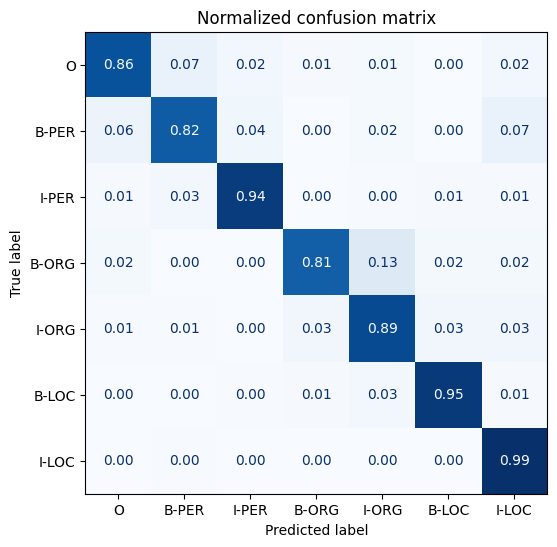

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6)) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
tags.names)

In [93]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,B-ORG,O,O,O,O,B-ORG,O,O,B-ORG,O,O,O,O,O,B-ORG,O
losses,0.00,0.00,5.18,0.00,0.00,0.00,12.52,13.08,9.16,11.77,12.77,0.00,12.18,12.67,0.00,12.18,12.79,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,10.87,0.00,0.00,5.70,9.74,10.31,8.02,0.00,8.59,10.50,7.98,8.02,7.35,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,8.53,7.15,7.52,0.00,7.67,0.00,7.56,0.00,7.36,7.54,7.58,7.93,7.38,7.11,0.00


In [94]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.02,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,B-LOC
losses,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Cross-Lingual Transfer

Now that we have fine-tuned XLM-R on German, we can evaluate its ability to transfer to other languages via the predict() method of the Trainer. Since we plan to evaluate multiple languages, let’s create a simple function that does this for us:

In [95]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [96]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score pf [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score pf [de] model on [de] dataset: 0.848


In [97]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [98]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1-score of [de] model on [fr] dataset: 0.709


Although we see a drop of about 14 points in the micro-averaged metrics, remember that our model has not seen a single labeled French example!

In [99]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

F1-score of [de] model on [it] dataset: 0.688


In [100]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

F1-score of [de] model on [en] dataset: 0.591
